<a href="https://colab.research.google.com/github/jyryu3161/2025_laidd_drugtarget/blob/main/lec3_deg_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydeseq2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.3/169.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 kB 5.2 MB/s eta 0:00:00


In [2]:
# 분석에 필요한 라이브러리 불러오기
import os
import unicodedata
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference

# Dropbox 직접 다운로드
URLurl = "https://www.dropbox.com/scl/fi/dsiabdm5flyzs8h3jrhqg/GSE66207_data.zip?rlkey=xghm3vaz0c86hj15pbfdxszwi&dl=1"

# 파일 다운로드
!wget -O GSE66207_data.zip "$URLurl"

# 압축 해제
!unzip -o GSE66207_data.zip -d ./GSE66207_data

# 결과 확인
!ls -R ./GSE66207_data

--2025-10-27 05:26:56--  https://www.dropbox.com/scl/fi/dsiabdm5flyzs8h3jrhqg/GSE66207_data.zip?rlkey=xghm3vaz0c86hj15pbfdxszwi&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uca48c0fc568c45c46db9fb7d749.dl.dropboxusercontent.com/cd/0/inline/C0DWCb43wF-LLPlggaojBQmYMPGSn8R5jxis0h6SgWFljyq07Iwye_F1Fy06JRRb9uResVcwcHAnJZkU9Z63sgZdlhr59KKLV_xGLRGV4klHGqshM7BZIKAy-W2IySF2Xw0RTqv6M3zv2hw1xY9DbgEf/file?dl=1# [following]
--2025-10-27 05:26:56--  https://uca48c0fc568c45c46db9fb7d749.dl.dropboxusercontent.com/cd/0/inline/C0DWCb43wF-LLPlggaojBQmYMPGSn8R5jxis0h6SgWFljyq07Iwye_F1Fy06JRRb9uResVcwcHAnJZkU9Z63sgZdlhr59KKLV_xGLRGV4klHGqshM7BZIKAy-W2IySF2Xw0RTqv6M3zv2hw1xY9DbgEf/file?dl=1
Resolving uca48c0fc568c45c46db9fb7d749.dl.dropboxusercontent.com (uca48c0fc568c45c46db9fb7d749.dl.dropboxusercontent.com)... 

In [3]:
# 1) 읽기: 행=gene, 열=sample
counts_df = pd.read_csv("./GSE66207_data/CD_rnaseq.csv", index_col=0)
metadata = pd.read_csv('./GSE66207_data/meta.csv', index_col=0)

# 2) gene symbol 정규화(공백/유니코드 차이로 인한 '겉만 다른' 중복 방지)
idx = counts_df.index.astype(str)
idx = [unicodedata.normalize("NFKC", x) for x in idx]  # 유니코드 정규화
counts_df.index = pd.Index(idx).str.strip().str.replace(r"\s+", " ", regex=True)

# 3) gene(인덱스) 중복 제거: 첫 번째만 남김
print("중복 gene 개수(제거 전):", counts_df.index.duplicated().sum())
counts_df = counts_df[~counts_df.index.duplicated(keep="first")].copy()

# (선택) 샘플명도 정규화 + 샘플 중복 제거
counts_df.columns = (
    counts_df.columns.astype(str).str.strip().str.replace(r"\s+", " ", regex=True)
)
if counts_df.columns.duplicated().any():
    print("경고: 샘플ID 중복이 있어 첫 번째만 사용합니다.")
    counts_df = counts_df.loc[:, ~counts_df.columns.duplicated(keep="first")].copy()

# 4) pydeseq2 입력 형태에 맞게 데이터 전치: 행=sample, 열=gene
counts_df = counts_df.T

print(counts_df)
print(metadata)

중복 gene 개수(제거 전): 2
     A1BG  A1BG-AS1  A1CF    A2M  A2M-AS1  A2ML1  A2MP1  A4GALT  A4GNT  AA06  \
20      3         0   721   1870       54      0      2      13      0     0   
21      4         5  2338   3166       91      1      2      18      0     0   
29      5         7  1710   7204      195      8      0      20      0     0   
51     29        44  2007  11503      325      9     15      55      2     0   
54     57        63  2531  24846      465      2      2     109      4     0   
62     29        34  1802  10269      208     11      3      60      0     0   
63     20        27  2146  20275      420      7      9     157      2     0   
64     37        25   383   4594      172      1      1      84      0     0   
405    11        17  2016   6791      165      1      2      39      1     0   
407    18        12  2077   7786      190      0      0      41      0     0   
408   121       122  5279  49815     1061     34      9     362      3     0   
413    25        30 

In [4]:
# DESeq2 데이터셋 객체 생성
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design="~condition",
    refit_cooks=True,
    inference=inference,
)

/usr/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


In [5]:
import pickle

# DESeq2 분석 파이프라인 실행
dds.deseq2()

# 분석이 완료된 dds 객체를 파일로 저장
with open("dds_fitted.pkl", "wb") as f:
    pickle.dump(dds, f)

Fitting size factors...
... done in 0.06 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 43.17 seconds.

Fitting dispersion trend curve...
... done in 0.79 seconds.

Fitting MAP dispersions...
... done in 52.09 seconds.

Fitting LFCs...
... done in 28.32 seconds.

Calculating cook's distance...
... done in 0.08 seconds.

Replacing 295 outlier genes.

Fitting dispersions...
... done in 0.63 seconds.

Fitting MAP dispersions...
... done in 0.71 seconds.

Fitting LFCs...
... done in 0.70 seconds.



In [6]:
# 통계 분석 결과 객체 생성
# contrast: condition 컬럼에서 'CD' 그룹을 'Normal' 그룹과 비교
stat_res = DeseqStats(dds, contrast=["condition", "CD", "Normal"], inference=inference)

# 분석 결과 요약 확인
# Log2FC > 0 이면 CD 그룹에서 발현량 증가를 의미합니다.
stat_res.summary()

# 분석 결과를 DataFrame으로 변환하여 저장
results_df = stat_res.results_df
results_df.to_csv('DEG_results.csv')

# 통계 결과 객체도 파일로 저장
with open("stat_results.pkl", "wb") as f:
    pickle.dump(stat_res, f)

print("\nDEG 분석 결과:")
print(results_df.head())

Running Wald tests...
... done in 7.30 seconds.



Log2 fold change & Wald test p-value: condition CD vs Normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        20.925708       -0.025239  0.286816 -0.087997  0.929879  0.977976
A1BG-AS1    22.512025       -0.218506  0.214707 -1.017692  0.308824  0.647309
A1CF      1796.398044        0.440247  0.253844  1.734321  0.082861  0.372567
A2M       9292.378972       -0.200669  0.137223 -1.462354  0.143644  0.470542
A2M-AS1    234.417208       -0.228729  0.139074 -1.644652  0.100042  0.401401
...               ...             ...       ...       ...       ...       ...
ZYG11A      10.478935       -0.291479  0.301674 -0.966203  0.333943  0.665971
ZYG11B    1003.789149       -0.223782  0.145143 -1.541801  0.123122  0.441117
ZYX        581.196622        0.234852  0.260281  0.902303  0.366896  0.688464
ZZEF1     4039.924242        0.681102  0.191059  3.564870  0.000364  0.025773
ZZZ3       682.118672       -0.131900  0.145529 -0.906352  0.364750  0.687629

[2

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Helvetica']

def plot_volcano(df, lfc_col="log2FoldChange", p_col="padj", alpha=0.05, lfc_thr=1.0):
    """
    Volcano plot을 그리는 함수
    """
    # 무한대 값을 NaN으로 변환 후 제거하고, p-value가 0인 경우를 대비해 아주 작은 값으로 클리핑
    data = df.copy().replace([np.inf, -np.inf], np.nan).dropna(subset=[lfc_col, p_col])
    data["neglog10p"] = -np.log10(data[p_col].clip(lower=1e-300))

    # 그룹 분류: Up-regulated, Down-regulated, Not significant
    sig_up = (data[p_col] < alpha) & (data[lfc_col] >= lfc_thr)
    sig_down = (data[p_col] < alpha) & (data[lfc_col] <= -lfc_thr)
    non_sig = ~(sig_up | sig_down)

    # 그룹별로 색상을 다르게 하여 산점도 그리기
    plt.figure(figsize=(8, 8))
    plt.scatter(data.loc[non_sig, lfc_col], data.loc[non_sig, "neglog10p"],
                s=8, alpha=0.5, c='gray', label='NS')
    plt.scatter(data.loc[sig_up, lfc_col], data.loc[sig_up, "neglog10p"],
                s=10, alpha=0.7, c='red', label='Up')
    plt.scatter(data.loc[sig_down, lfc_col], data.loc[sig_down, "neglog10p"],
                s=10, alpha=0.7, c='blue', label='Down')

    # Log2FC와 p-value 임계선을 점선으로 표시
    plt.axvline(lfc_thr, color='k', ls='--', lw=0.5)
    plt.axvline(-lfc_thr, color='k', ls='--', lw=0.5)
    plt.axhline(-np.log10(alpha), color='k', ls='--', lw=0.5)

    plt.xlabel("log2 Fold Change")
    plt.ylabel("-log10(adjusted p-value)")
    plt.title("Volcano Plot")
    plt.legend(loc='upper right', fontsize=8)
    plt.show()

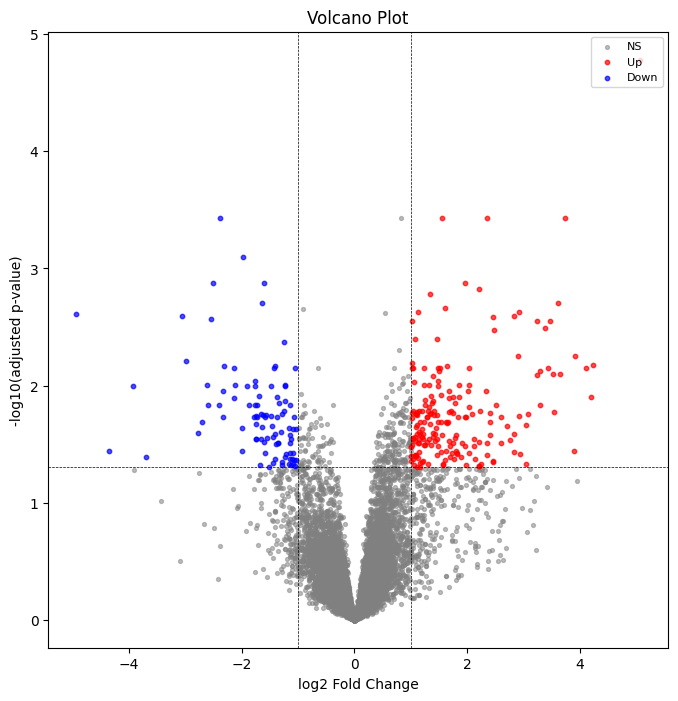

In [8]:
# Volcano plot 그리기
plot_volcano(results_df)